In [1]:
import os
from pathlib import Path
# import nfp
import numpy as np
import pandas as pd
import tarfile
from pymatgen.core import Structure
import json
import gzip
import re
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', 
        # font_scale=8/8.8,
        style='ticks',
        color_codes=True, 
        rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'
# plt.rc('axes', labelsize=11)
# plt.rc('legend', fontsize=11)

%matplotlib inline

In [3]:
# This file has the predicted energies for all structures in the train, valid and test set
# We will use it to plot the test err
base_dir = "/projects/rlmolecule/jlaw/projects/upper-bound-energy-gnn-fork"
pred_energies_file = Path(base_dir, "pretrained_models/predicted_energies.csv.gz")
df_pred = pd.read_csv(pred_energies_file, index_col=0)
df_pred.head(2)

,id,composition,energyperatom,volume,num_sites,dataset,scale_factor,set,energy_predicted
0,icsd_000008,Ba1S3Te1,-4.37838,565.32959,20,icsd,0.424954,train,-4.370380
1,icsd_000012,Cl7Ga2K1,-3.34424,1132.18244,40,icsd,0.471884,train,-3.364022


In [4]:
df_pred.dataset.value_counts()

vol      58669
relax    52949
icsd     16409
Name: dataset, dtype: int64

In [5]:
df_pred.set.value_counts()

train               123914
valid                 1500
test                  1500
test_composition      1113
Name: set, dtype: int64

In [6]:
df_pred['energy_err'] = (df_pred['energyperatom'] - df_pred['energy_predicted']).abs()
df_pred.groupby(['set', 'dataset']).energy_err.mean().unstack().round(3)

dataset,icsd,relax,vol
set,,,
test,0.045,0.034,0.050
test_composition,0.048,0.036,0.065
train,0.035,0.028,0.035
valid,0.052,0.038,0.048


In [7]:
test_data = df_pred[df_pred.set == "test"]
test_data.sort_values('dataset', ascending=False, inplace=True)
test_data.head(2)

/tmp/ipykernel_21587/208845463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.sort_values('dataset', ascending=False, inplace=True)


,id,composition,energyperatom,volume,num_sites,dataset,scale_factor,set,energy_predicted,energy_err
127968,Zn5S2P2_sg15_icsd_036063_2,Zn5S2P2,-2.53878,937.83035,36,vol,0.475066,test,-2.550149,0.011369
87545,Li2Sb1Cl7_sg65_icsd_174209_1,Li2Sb1Cl7,-2.46500,452.62000,20,vol,0.421698,test,-2.490621,0.025621


In [8]:
# use the average from the learning curve
maes = {
    "icsd": 0.046,
    "relax": 0.032,
    "vol": 0.045,
}

In [11]:
colors = {'icsd': "#32353b",  # gray
          'relax': "#5b6cdd",  # blue
          'vol': "#c67884",  # salmon
         }

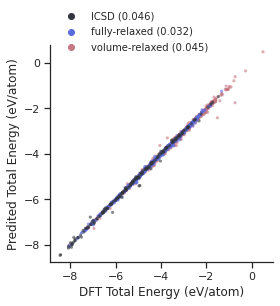

In [12]:
# f, ax = plt.subplots(figsize=(4,4))
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')
g = sns.scatterplot(data=test_data, x="energyperatom", y="energy_predicted", 
                hue="dataset", hue_order=["icsd", "relax", "vol"],
                alpha=.6, s=10, linewidth=0, 
                    palette=colors,
               )
g.legend_.set_title(None)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.2))

new_labels = ['ICSD', 'fully-relaxed', 'volume-relaxed']
for t, l in zip(ax.legend_.texts, new_labels):
    data_type = t.get_text()
    # df = test_data[test_data.type == data_type]
    # mae = (df.energyperatom - df.energy_predicted).abs().mean()
    mae = maes[data_type]
    new_label = f"{l} ({mae})"
    t.set_text(new_label)
    t.set_fontsize(10)

plt.xlabel("DFT Total Energy (eV/atom)")
plt.ylabel("Predited Total Energy (eV/atom)")

sns.despine()

# plt.title("Training data: ICSD, Battery Relaxed")
# out_file = f"test_err_scatter.svg"
# print(os.path.abspath(out_file))
# plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg', '.png'), bbox_inches='tight', dpi=300)